In [1]:
# importar librerías
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt

Primero importaremos las librerías necesarias para examinar las tablas; esto nos permitirá obtener una visión general de los datos.

In [2]:
# cargar archivos
traffic = pd.read_csv('C:/Users/pasty/Documents/datasets/tomtom_traffic.csv')
eco = pd.read_csv('C:/Users/pasty/Documents/datasets/oecd_city_economy.csv')

In [3]:
# mostrar las primeras 5 filas de traffic
traffic.head(5)

,Country,City,UpdateTimeUTC,JamsDelay,TrafficIndexLive,JamsLengthInKms,JamsCount,TrafficIndexWeekAgo,UpdateTimeUTCWeekAgo,TravelTimeLivePer10KmsMins,TravelTimeHistoricPer10KmsMins,MinsDelay
0,ARE,abu-dhabi,2025-01-13 04:01:30.001,650.7,36.0,109.1,162.0,30.0,2025-01-06 04:01:30.000,11.614767,10.265330,1.349437
1,ARE,abu-dhabi,2025-01-13 03:46:00.000,540.4,30.0,101.4,136.0,27.0,2025-01-06 03:46:30.001,11.003180,10.031544,0.971635
2,ARE,abu-dhabi,2025-01-13 02:46:30.000,71.8,7.0,18.9,23.0,6.0,2025-01-06 02:46:30.000,8.196278,8.196510,-0.000232
3,ARE,abu-dhabi,2025-01-13 01:46:30.001,8.2,2.0,4.1,2.0,2.0,2025-01-06 01:46:30.000,7.723808,7.899046,-0.175238
4,ARE,abu-dhabi,2025-01-13 00:01:30.000,1.1,1.0,0.2,1.0,1.0,2025-01-06 00:01:30.000,8.336363,8.604379,-0.268016


In [4]:
# Examinar la estructura de traffic
traffic.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004464 entries, 0 to 1004463
Data columns (total 12 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Country                         1004464 non-null  object 
 1   City                            1004464 non-null  object 
 2   UpdateTimeUTC                   1004464 non-null  object 
 3   JamsDelay                       1004464 non-null  float64
 4   TrafficIndexLive                1004464 non-null  float64
 5   JamsLengthInKms                 1004464 non-null  float64
 6   JamsCount                       1004464 non-null  float64
 7   TrafficIndexWeekAgo             1004464 non-null  float64
 8   UpdateTimeUTCWeekAgo            1004464 non-null  object 
 9   TravelTimeLivePer10KmsMins      1004464 non-null  float64
 10  TravelTimeHistoricPer10KmsMins  1004464 non-null  float64
 11  MinsDelay                       1004464 non-null  float64
dtype

In [5]:
# mostrar las primeras 5 filas de eco
eco.head(5)

,Year,City,Country,City GDP/capita,Unemployment %,PM2.5 (μg/m³),Population (M)
0,2023,buenos-aires,Argentina,"15.782,00",6.2%,"15,2","15,30"
1,2023,sao-paulo,Brazil,"14.475,00",9.1%,"29,50","22,50"
2,2023,rio-de-janeiro,Brazil,"13.142,00",9.8%,"19,10","13,60"
3,2023,brasilia,Brazil,"15.999,00",8.3%,"13,50","4,70"
4,2023,salvador,Brazil,"8.761,00",13.1%,"16,00","3,90"


In [6]:

# Examinar la estructura de eco
eco.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Year             30 non-null     int64 
 1   City             30 non-null     object
 2   Country          30 non-null     object
 3   City GDP/capita  30 non-null     object
 4   Unemployment %   30 non-null     object
 5   PM2.5 (μg/m³)    30 non-null     object
 6   Population (M)   30 non-null     object
dtypes: int64(1), object(6)
memory usage: 1.8+ KB


Con el panorama general claro, procederemos a modificar los nombres de las columnas. El objetivo es facilitar la unión entre tablas y asignar nombres más intuitivos que mejoren la legibilidad de los datos.

In [7]:
# Estandarizar los nombres de las columnas de traffic
traffic=traffic.rename(columns={'Country':'country', 'City':'city', 'UpdateTimeUTC':'Update_Time_UTC', 'JamsDelay':'Jams_Delay', 'TrafficIndexLive':'Traffic_Index_Live',
       'JamsLengthInKms':'Jams_Length_In_Kms', 'JamsCount':'Jams_Count', 'TrafficIndexWeekAgo':'Traffic_Index_Week_Ago',
       'UpdateTimeUTCWeekAgo':'Update_Time_UTC_Week_Ago', 'TravelTimeLivePer10kmsMins':'Travel_Time_Live_Per_10_kms_Mins',
       'TravelTimeHistoricPer10KmsMins':'Travel_Time_Historic_Per_10_Kms_Mins','MinsDelay': 'Mins_Delay'})

traffic.columns=traffic.columns.str.lower()

# verificar cambios
traffic.columns


Index(['country', 'city', 'update_time_utc', 'jams_delay',
       'traffic_index_live', 'jams_length_in_kms', 'jams_count',
       'traffic_index_week_ago', 'update_time_utc_week_ago',
       'traveltimeliveper10kmsmins', 'travel_time_historic_per_10_kms_mins',
       'mins_delay'],
      dtype='object')

In [8]:
# Estandarizar los nombres de las columnas de eco
eco=eco.rename(columns={'Year':'year','City':'city','Country':'country','City GDP/capita':'city_gdp_capita','Population (M)':'population_m','PM2.5 (μg/m³)':'PM2.5(μg/m³)','Unemployment %':'unemployment_pct'})
# verificar cambios
eco.columns

Index(['year', 'city', 'country', 'city_gdp_capita', 'unemployment_pct',
       'PM2.5(μg/m³)', 'population_m'],
      dtype='object')

Para continuar con la unión, debemos estandarizar los tipos de datos; es decir, corregir espacios, puntos y guiones, o convertir valores de texto a formato numérico o de fecha. Esto tiene como fin facilitar la integración y el trabajo posterior con el dataset.

In [9]:
# Convertir las columnas de traffic a tipo fecha con pd.to_datetime()
traffic['update_time_utc'] =pd.to_datetime(traffic['update_time_utc'],errors='coerce',utc=True) 
traffic['update_time_utc_week_ago'] =pd.to_datetime(traffic['update_time_utc_week_ago'],errors='coerce',utc=True) 

traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004464 entries, 0 to 1004463
Data columns (total 12 columns):
 #   Column                                Non-Null Count    Dtype              
---  ------                                --------------    -----              
 0   country                               1004464 non-null  object             
 1   city                                  1004464 non-null  object             
 2   update_time_utc                       1004464 non-null  datetime64[ns, UTC]
 3   jams_delay                            1004464 non-null  float64            
 4   traffic_index_live                    1004464 non-null  float64            
 5   jams_length_in_kms                    1004464 non-null  float64            
 6   jams_count                            1004464 non-null  float64            
 7   traffic_index_week_ago                1004464 non-null  float64            
 8   update_time_utc_week_ago              1004464 non-null  datetime64[ns, U

In [10]:
# Limpia separadores y convierte columnas numéricas en eco
eco['city_gdp_capita'] =eco['city_gdp_capita'].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)
eco['unemployment_pct'] =eco['unemployment_pct'].astype(str).str.replace('%', '').str.replace(',', '.').astype(float) 
eco['population_m'] =eco['population_m'].astype(str).str.replace(',', '.').astype(float)

# Calcula la población total en unidades absolutas (Multiplica * 1000000)
eco['population'] = eco['population_m']*1000000


# verificar el cambio
eco.info()
eco.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              30 non-null     int64  
 1   city              30 non-null     object 
 2   country           30 non-null     object 
 3   city_gdp_capita   30 non-null     float64
 4   unemployment_pct  30 non-null     float64
 5   PM2.5(μg/m³)      30 non-null     object 
 6   population_m      30 non-null     float64
 7   population        30 non-null     float64
dtypes: float64(4), int64(1), object(3)
memory usage: 2.0+ KB


,year,city,country,city_gdp_capita,unemployment_pct,PM2.5(μg/m³),population_m,population
0,2023,buenos-aires,Argentina,15782.0,6.2,"15,2",15.3,15300000.0
1,2023,sao-paulo,Brazil,14475.0,9.1,"29,50",22.5,22500000.0
2,2023,rio-de-janeiro,Brazil,13142.0,9.8,"19,10",13.6,13600000.0


En este apartado, extraemos el año de las fechas para delimitar nuestro análisis. Para este proyecto, trabajaremos específicamente con los datos correspondientes al 2024

In [11]:
# Extraer el año de las fechas en update_time_utc
traffic['year'] = traffic['update_time_utc'].dt.year

# Verificar cambio
traffic.head(3)

,country,city,update_time_utc,jams_delay,traffic_index_live,jams_length_in_kms,jams_count,traffic_index_week_ago,update_time_utc_week_ago,traveltimeliveper10kmsmins,travel_time_historic_per_10_kms_mins,mins_delay,year
0,ARE,abu-dhabi,2025-01-13 04:01:30.001000+00:00,650.7,36.0,109.1,162.0,30.0,2025-01-06 04:01:30+00:00,11.614767,10.265330,1.349437,2025
1,ARE,abu-dhabi,2025-01-13 03:46:00+00:00,540.4,30.0,101.4,136.0,27.0,2025-01-06 03:46:30.001000+00:00,11.003180,10.031544,0.971635,2025
2,ARE,abu-dhabi,2025-01-13 02:46:30+00:00,71.8,7.0,18.9,23.0,6.0,2025-01-06 02:46:30+00:00,8.196278,8.196510,-0.000232,2025


In [12]:
# Filtra los registros del año 2024
traffic_2024 = traffic[traffic['year']==2024] .copy()
eco_2024 = eco[eco['year']==2024] .copy()

# Revisar dataframes nuevos
display(traffic_2024.head())
display(eco_2024.head())

,country,city,update_time_utc,jams_delay,traffic_index_live,jams_length_in_kms,jams_count,traffic_index_week_ago,update_time_utc_week_ago,traveltimeliveper10kmsmins,travel_time_historic_per_10_kms_mins,mins_delay,year
302,ARE,abu-dhabi,2024-12-31 23:01:30+00:00,12.9,5.0,2.5,5.0,2.0,2024-12-24 23:01:30.001000+00:00,8.560399,8.519634,0.040765,2024
303,ARE,abu-dhabi,2024-12-31 22:01:30+00:00,136.0,21.0,20.6,32.0,3.0,2024-12-24 22:01:30+00:00,10.355732,9.049445,1.306286,2024
304,ARE,abu-dhabi,2024-12-31 21:16:30+00:00,455.2,31.0,40.4,72.0,4.0,2024-12-24 21:01:30+00:00,11.456878,9.305174,2.151704,2024
305,ARE,abu-dhabi,2024-12-31 20:01:00.001000+00:00,399.4,27.0,38.0,75.0,6.0,2024-12-24 20:01:30.001000+00:00,11.670062,9.952811,1.717252,2024
306,ARE,abu-dhabi,2024-12-31 19:46:00+00:00,366.4,28.0,39.8,82.0,9.0,2024-12-24 19:01:00+00:00,11.686322,10.008469,1.677853,2024


,year,city,country,city_gdp_capita,unemployment_pct,PM2.5(μg/m³),population_m,population
15,2024,buenos-aires,Argentina,18117.0,7.2,"14,50",15.4,15400000.0
16,2024,sao-paulo,Brazil,14703.0,8.5,"28,00",22.6,22600000.0
17,2024,rio-de-janeiro,Brazil,13349.0,9.2,"18,40",13.7,13700000.0
18,2024,brasilia,Brazil,16251.0,7.8,"12,80",4.8,4800000.0
19,2024,salvador,Brazil,8899.0,12.4,"15,20",3.9,3900000.0


También es importante definir qué mediciones y agrupaciones utilizaremos para facilitar tanto la lectura como la interpretación de los resultados.

In [13]:
# Calcular los  promedios de trafico por ciudad, país y año
traffic_city_year_2024 = traffic_2024.groupby(['city', 'country', 'year'])[['jams_delay','traffic_index_live','jams_length_in_kms','jams_count','mins_delay','traveltimeliveper10kmsmins','travel_time_historic_per_10_kms_mins']].mean().reset_index() 
# Mostrar resultado
traffic_city_year_2024.head()

,city,country,year,jams_delay,traffic_index_live,jams_length_in_kms,jams_count,mins_delay,traveltimeliveper10kmsmins,travel_time_historic_per_10_kms_mins
0,a-coruna,ESP,2024,17.935187,15.259774,2.198002,4.934405,0.774172,16.267977,15.493804
1,aachen,DEU,2024,26.732141,20.960314,3.892586,6.601832,0.792968,13.397861,12.604894
2,aarhus,DNK,2024,21.200616,16.575891,2.736736,6.109987,0.495276,15.219292,14.724016
3,abu-dhabi,ARE,2024,171.157315,13.902028,24.507380,47.268019,0.139764,9.829092,9.689328
4,adana,TUR,2024,83.864761,22.541040,11.827331,23.754620,1.129749,15.879694,14.749945


In [14]:
#ordenamiento de datos por jams_delay descendente
traffic_city_year_2024.sort_values(["jams_delay"], ascending=False)

,city,country,year,jams_delay,traffic_index_live,jams_length_in_kms,jams_count,mins_delay,traveltimeliveper10kmsmins,travel_time_historic_per_10_kms_mins
221,mexico-city,MEX,2024,2833.057892,34.218190,389.239265,594.969392,1.855542,21.809092,19.953550
352,tokyo,JPN,2024,2152.574357,36.805059,373.069734,518.809420,0.698152,22.443778,21.745626
246,new-york,USA,2024,2133.400000,28.210388,398.227892,544.474902,1.396351,18.505043,17.108691
200,london,GBR,2024,2050.703662,29.230166,287.632868,471.795554,1.325160,17.714139,16.388979
211,manila,PHL,2024,1741.493381,66.129402,246.858082,341.881205,2.469894,27.134629,24.664734
...,...,...,...,...,...,...,...,...,...,...
111,dunedin,NZL,2024,4.651175,15.430809,0.712315,1.591384,0.633294,16.226009,15.592715
363,uppsala,SWE,2024,4.194486,13.939168,0.656368,1.349672,0.501802,15.746717,15.244916
123,fujairah,ARE,2024,4.025959,10.907719,0.731910,1.373006,0.194951,11.662590,11.467639
12,almere,NLD,2024,3.633523,6.290478,0.506362,1.064063,-0.017544,9.467150,9.484694


Llegamos al paso de la unión de tablas, donde definiremos qué columnas integrar y cuál será la clave en común. En todo momento, priorizamos que la tabla resultante esté ordenada y contenga únicamente los datos más relevantes para el análisis.

In [15]:
# Seleccionar columnas clave de tráfico y economía
left_cols = ['year', 'city', 'jams_delay','traffic_index_live', 'jams_length_in_kms', 'jams_count','mins_delay']

right_cols = ['year', 'city', 'country', 'city_gdp_capita', 'unemployment_pct','PM2.5(μg/m³)', 'population']

# Usar .copy() para crear los dos nuevos datasets reducidos
traffic_2024_small = traffic_city_year_2024[left_cols].copy()
eco_2024_small = eco_2024[right_cols].copy()

# Unir datasets
merged = pd.merge(traffic_2024_small,eco_2024_small, on=['year', 'city'],how='inner') # tu código aquí

# Mostrar las primeras 5 filas
print(merged.head())
print(merged.columns.tolist())
# reordenar columnas
columnas_ordenadas=['year', 'city','country', 'jams_delay', 'traffic_index_live', 'mins_delay', 'city_gdp_capita', 'unemployment_pct', 'population']
print(merged['city'].unique().tolist())
print(merged['country'].unique().tolist())
merged=merged[columnas_ordenadas]
print(merged.head())

   year            city   jams_delay  traffic_index_live  jams_length_in_kms  \
0  2024  belo-horizonte   263.047879           19.428946           44.038129   
1  2024          bogota  1141.552364           37.614273          140.893564   
2  2024        brasilia   101.576326           11.258220           18.337133   
3  2024    buenos-aires   571.089593           17.756012          100.287844   
4  2024        curitiba   183.469274           14.954545           30.050044   

   jams_count  mins_delay    country  city_gdp_capita  unemployment_pct  \
0   68.805422    0.487228     Brazil          11124.0               9.5   
1  230.566550    1.699628   Colombia          11442.0              10.0   
2   27.280140    0.193442     Brazil          16251.0               7.8   
3  137.359860    0.416566  Argentina          18117.0               7.2   
4   46.898164    0.139965     Brazil          12381.0               8.2   

  PM2.5(μg/m³)  population  
0        16,80   6100000.0  
1        1

Generamos gráficos para visualizar la distribución de los datos, comenzando por el tráfico. Al observar el boxplot, notamos una gran dispersión en los retrasos (jams_delay) y la presencia de valores atípicos, aunque el promedio general se sitúa en 629.52.

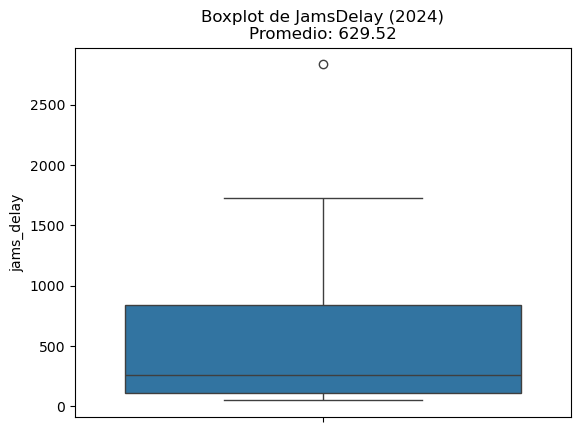

In [16]:
mean_value = merged['jams_delay'].mean()
sns.boxplot(data=merged,y='jams_delay')
plt.title(f'Boxplot de JamsDelay (2024)\nPromedio: {mean_value:.2f}')
plt.show()


En segundo lugar, analizaremos la distribución del ingreso per cápita por ciudad. A través de este histograma, observamos que la mayoría de las ciudades se concentran en un rango cercano al promedio de 13,253.60 USD, aunque existe una dispersión importante con casos que superan los 
20,000 USD y en el caso menor de 5,000 USD.

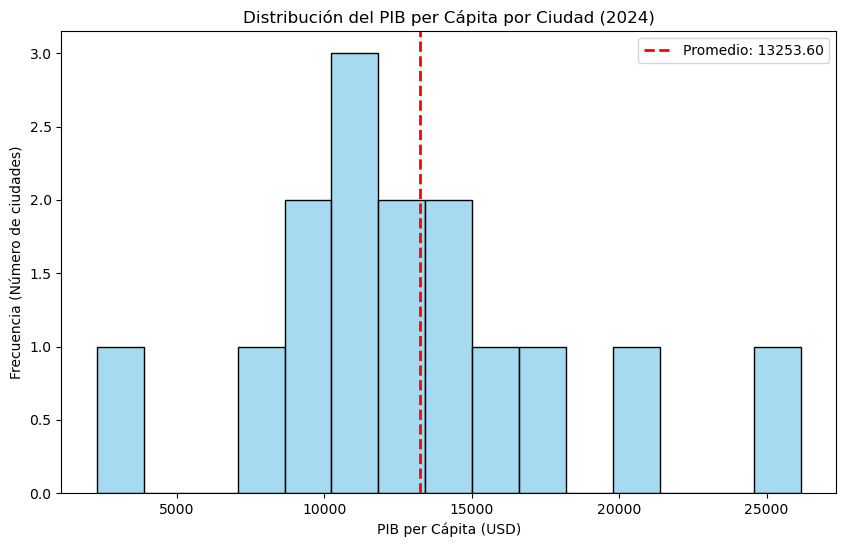

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(merged['city_gdp_capita'],color='skyblue', bins=15)
promedio_gdp = merged['city_gdp_capita'].mean()
plt.axvline(promedio_gdp, color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedio_gdp:.2f}')
plt.title('Distribución del PIB per Cápita por Ciudad (2024)')
plt.xlabel('PIB per Cápita (USD)')
plt.ylabel('Frecuencia (Número de ciudades)')
plt.legend()
plt.show()


Por último, evaluamos la relación entre el tráfico y el ingreso per cápita. Aunque se podría pensar que un mayor ingreso implica mayor tráfico, los gráficos sugieren que existen otros factores determinantes. Se puede suponer que factores como el diseño urbanístico, la eficiencia del transporte público o la infraestructura vial parecen tener un impacto más significativo en la congestión que el nivel económico por sí solo.

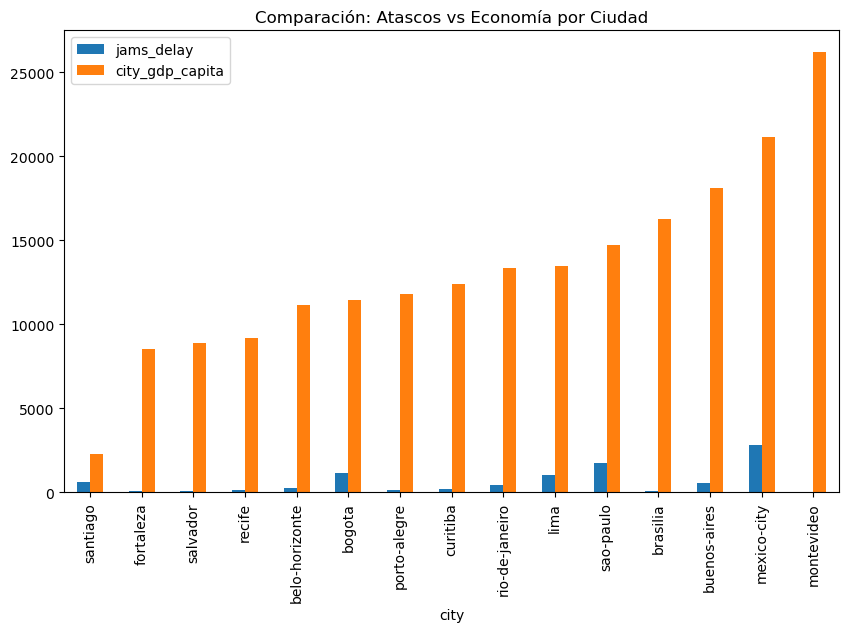

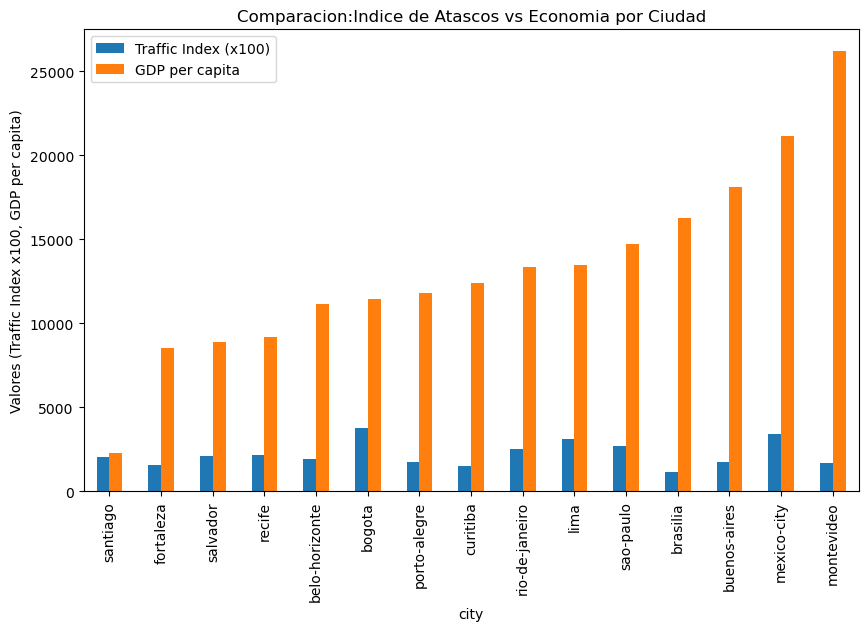

In [18]:
merged_ordenado = merged.sort_values(by='city_gdp_capita', ascending=True)
merged_ordenado.plot(x='city', y=['jams_delay', 'city_gdp_capita'], kind='bar', figsize=(10,6))
plt.title('Comparación: Atascos vs Economía por Ciudad')
plt.xticks(rotation=90)
plt.show()

merged_plot = merged_ordenado.copy()
merged_plot['traffic_index_scaled'] = merged_plot['traffic_index_live'] * 100
merged_plot.plot(x='city', y=['traffic_index_scaled', 'city_gdp_capita'], kind='bar', figsize=(10,6))
plt.title('Comparacion:Indice de Atascos vs Economia por Ciudad')
plt.ylabel('Valores (Traffic Index x100, GDP per capita)')
plt.xticks(rotation=90)
plt.legend(['Traffic Index (x100)', 'GDP per capita'])
plt.show()

In [19]:
# Exporta el dataset final como CSV
merged.to_csv('movilidad_economica_final.csv', index=False, encoding='utf-8-sig')